In [17]:
import os
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mayavi import mlab
from tvtk.api import tvtk
from tvtk.common import configure_input_data
from surfer import Brain
import nibabel as nib
import experiments.utils as utils
from importlib import reload

os.environ['SUBJECTS_DIR'] = '/Users/admin/Dropbox (Weizmann Institute)/tunnel/freesurfer_subjects'
cortical_maps_path = '/Users/admin/Dropbox (Weizmann Institute)/tunnel/cortical_maps'
# cmap_GBR = LinearSegmentedColormap.from_list('mycmap', ['green', 'blue', 'red', ])
cmap_GBR = LinearSegmentedColormap.from_list('mycmap', ['lime', 'blue', 'red', ])

sbj_idx = 3
sbj_fs_name = 'Kamitani_sbj%d' % sbj_idx
# background_color = 'white'
background_color = 'black'

def add_rgba(fig, brain, rgba_vals, flatpatch=False):
    x, y, z = brain.geo[hemi].coords.T
    tris = brain.geo[hemi].faces
    
    mesh = mlab.pipeline.triangular_mesh_source(x, y, z, tris, figure=fig)
    mesh.data.point_data.scalars.number_of_components = 4  # r, g, b, a
    mesh.data.point_data.scalars = (rgba_vals * 255).astype('ubyte')
    
    mapper = tvtk.PolyDataMapper()
    configure_input_data(mapper, mesh.data)
    actor = tvtk.Actor()
    actor.mapper = mapper
    fig.scene.add_actor(actor)

def get_scalar_data(overlay_name):
    overlay_path = os.path.join(cortical_maps_path, overlay_name + '.nii')
    return ravel(nib.load(overlay_path).get_data(), order='F')
    
def plot_brain(overlay_name, overlay_name_alpha, hemi, minmax=None, alpha_min=0.2, alpha_sat=90, flatpatch=True,  
               cmap=plt.cm.rainbow, cortex='low_contrast'):
    scalar_data = get_scalar_data(overlay_name + '_' + hemi)
    scalar_data_alpha = get_scalar_data(overlay_name_alpha + '_' + hemi)

    # if nanmedian(scalar_data) < 0:
    #     scalar_data *= -1
    scalar_data = abs(scalar_data)  # For polar angle
    if minmax is None:
        minmax = nanmin(scalar_data), nanmax(scalar_data)
    print('min, max:', [round(v,2) for v in minmax])
    hue = nan_to_num(interp(scalar_data, minmax, (0, 1)))
    if cmap is None:
        cmap = cmap_RBG
    colors = cmap(hue)[:, :3]
    alpha = (~np.isnan(scalar_data)).astype('float32')
    alpha *= interp(scalar_data_alpha, (nanmin(scalar_data_alpha), np.nanpercentile(scalar_data_alpha, alpha_sat)), (alpha_min, 1))
    rgba_vals = np.concatenate((colors, alpha[:, None]), axis=1)
    
    fig = mlab.figure()
    if flatpatch:
        b = Brain(sbj_fs_name, hemi, 'full.flat.patch.3d', background=background_color, figure=fig, cortex=cortex)
        # print('original rgba_vals.shape:',rgba_vals.shape)
        rgba_vals = b.geo[hemi].surf_to_patch_array(rgba_vals)
        # print('patch-compatible rgba_vals.shape:',rgba_vals.shape)
    
        # cam = fig.scene.camera
        # cam.zoom(1.85)
        mlab.move(up=-40, right=((hemi == 'lh')*2-1)*50, forward=170)
    else:
        b = Brain(sbj_fs_name, hemi, 'inflated',  background=background_color, figure=fig, cortex=cortex,)
        # mlab.view(azimuth=-77 if hemi == 'lh' else 253, elevation=115)
        mlab.view(azimuth=-70 if hemi == 'lh' else 245, elevation=115)        
        if hemi == 'rh':
            # mlab.view(roll=152)
            mlab.view(roll=144)
            mlab.move(right=90)
        else:  # lh
            mlab.move(right=-90)
                        
        # cam = fig.scene.camera
        # cam.view zoom(1.85)
        
    add_rgba(fig, b, rgba_vals)
    # mlab.savefig(cortical_maps_path + '/pysurfer/{}_{}{}.tiff'.format(overlay_name, hemi, '_flat' if flatpatch else ''), figure=fig, magnification=5)
    mlab.savefig(cortical_maps_path + '/pysurfer/{}_{}{}.tiff'.format(overlay_name, hemi, '_flat' if flatpatch else ''), figure=fig, magnification=2)    
    # mlab.savefig(cortical_maps_path + '/pysurfer/{}_{}{}.tiff'.format(overlay_name, hemi, '_flat' if flatpatch else ''), figure=fig)

In [18]:
data_items = {'corr': [None, plt.cm.hot], 'eccent': [None, plt.cm.plasma], 'polar': [(0,180), cmap_GBR], 'rf_size': [(2, 12), plt.cm.rainbow_r]}
# plt.cm.rainbow
# prefix = 'fsl_10k'
prefix = '0804'
overlay_name_alpha = '{}_snr_{}'.format(prefix, sbj_fs_name) 

for dataname, metadata in data_items.items():
    for hemi in ['lh', 'rh']:
        for flatpatch in [True, False]:
            print(dataname, hemi, 'flat' if flatpatch else '')
            overlay_name = '{}_{}_{}'.format(prefix, dataname, sbj_fs_name)
            # if 'polar' not in overlay_name:
            #     break
            if 'rf_size' not in overlay_name:
                break
            plot_brain(overlay_name, overlay_name_alpha, hemi, 
                       minmax=metadata[0], alpha_min=0.15, alpha_sat=85, flatpatch=flatpatch,
                       cmap=metadata[1], cortex='low_contrast')
            # break

corr lh flat
corr rh flat
eccent lh flat
eccent rh flat
polar lh flat
polar rh flat
rf_size lh flat
min, max: [2, 12]


rf_size lh 
min, max: [2, 12]


rf_size rh flat
min, max: [2, 12]


rf_size rh 
min, max: [2, 12]


In [6]:
scalar_data = get_scalar_data('0804_polar_Kamitani_sbj3_lh')

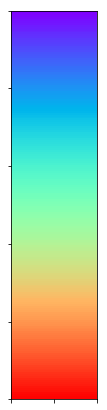

In [16]:
# Make legends
reload(utils)
# 
# utils.make_polar_legend(cmap=cmap_GBR)
# plt.savefig(cortical_maps_path + '/pysurfer/polar_legend.tiff', facecolor='black')
# 
# utils.make_eccent_legend(cmap=plt.cm.plasma) 
# plt.savefig(cortical_maps_path + '/pysurfer/eccent_legend.tiff', facecolor='black')
# 
# utils.make_legend(cmap=plt.cm.hot) 
# plt.savefig(cortical_maps_path + '/pysurfer/corr_legend.tiff', facecolor='black')

# utils.make_legend(cmap=plt.cm.cool) 
utils.make_legend(cmap=plt.cm.rainbow_r)
plt.savefig(cortical_maps_path + '/pysurfer/rf_size_legend.tiff', facecolor='black')

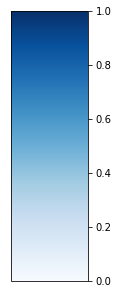

In [57]:
import pylab as pl
import numpy as np